In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import json

from src.utils import SimpleLogger
import src.utils as utils

# from src.preprocess import Preprocessor

config = utils.load_config()

logger = SimpleLogger(name="Logger-main", log_path="logs/logger_main_private7.5.log")


VAR_MAP = {
    "swvl1": "swvl1",
    "ro": "ro",
    "e": "e",
    "tp": "tp"
}

CHANNELS = {
    "swvl1": 0,
    "ro": 1,
    "e": 2,
    "tp": 3
}

from src.visualize import ArrayInfoDisplayer

array_info_displayer = ArrayInfoDisplayer(logger=logger)

In [2]:
# shows the config we are using
logger.info("Using config:\n" + json.dumps(config, indent=2, ensure_ascii=False))

[2025-07-21 19:48:37.577] [INFO] Using config:
{
  "model": "empty_model",
  "per_year_outputs_path": "/mnt/c/Users/jebediahc/OneDrive/鱼丸车仔/TUM-before-arrival/Project Earth Observation Data Analysis/Project-files-Soil-Moisture/per_year_outputs/",
  "date": "2020-01-15",
  "raw_path": "data/raw",
  "processed_path": "data/processed",
  "demo_path": "data/demo",
  "demo_nc_path": "data/demo/2020-1.nc",
  "demo_datetime": "2020-01-01T12:00:00",
  "months": [
    "2020-1",
    "2020-2",
    "2020-3",
    "2020-4",
    "2020-5",
    "2020-6",
    "2020-7"
  ],
  "run_name": "test-3",
  "raw_folder": "data/raw",
  "intermediate_folder": "data/processed",
  "use_channels": [
    "swvl1",
    "ro",
    "e",
    "tp"
  ],
  "input_days": 20,
  "predict_days": 10,
  "batch_size": 4,
  "epochs": 100
}


In [3]:
# --- STEP 1: LAT/LON and NetCDF info---
# Show NetCDF file format info
sample_nc = xr.open_dataset(os.path.join(config["raw_folder"], f"{config['months'][0]}.nc"))

lat = sample_nc['latitude'].values
lon = sample_nc['longitude'].values

print(sample_nc)
print("\nNetCDF file info:")
sample_nc.info()

# --- 陆地掩膜生成与应用（海洋去除）---
# # 读取第一个月的 NetCDF 文件，假设掩膜变量名为 'lsm'，如无请修改为实际变量名
# if 'lsm' in sample_nc.variables:
#     land_mask = sample_nc['lsm'].values  # shape: (lat, lon)，1为陆地，0为海洋
#     # 若掩膜有时间维度，取第一个时间点
#     if land_mask.ndim == 3:
#         land_mask = land_mask[0]
# else:
#     # 若无掩膜变量，可用经纬度范围简单生成（仅示例，建议用真实掩膜）
#     lat = sample_nc['latitude'].values
#     lon = sample_nc['longitude'].values
#     land_mask = np.ones((lat.shape[0], lon.shape[0]), dtype=np.float32)
#     # 可在此处用地理数据进一步筛选
# print(f"Land mask shape: {land_mask.shape}, 陆地像元数: {np.sum(land_mask)}")

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 744, latitude: 371, longitude: 701)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2020-01-01 ... 2020-01-31T23:...
  * latitude    (latitude) float64 3kB 72.0 71.9 71.8 71.7 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 6kB -25.0 -24.9 -24.8 ... 44.8 44.9 45.0
    expver      (valid_time) <U4 12kB ...
Data variables:
    swvl1       (valid_time, latitude, longitude) float32 774MB ...
    ro          (valid_time, latitude, longitude) float32 774MB ...
    e           (valid_time, latitude, longitude) float32 774MB ...
    tp          (valid_time, latitude, longitude) float32 774MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:               

In [4]:
# --- STEP 2: PROCESS & SAVE DAILY AVERAGED FILES ---
def process_month_to_daily_mean(month_str):
    input_path = os.path.join(config["raw_folder"], f"{month_str}.nc")
    output_path = os.path.join(config["intermediate_folder"], f"{month_str}.npy")
    ds = xr.open_dataset(input_path)
    var_stack = []

    for var in config["use_channels"]:
        var_data = ds[VAR_MAP[var]].values  # (time, lat, lon)
        total_hours = var_data.shape[0]
        days = total_hours // 24
        daily_data = var_data[:days * 24].reshape(days, 24, *var_data.shape[1:]).mean(axis=1)  # (days, lat, lon)
        daily_data = np.nan_to_num(daily_data, nan=0.0)
        # 应用掩膜，海洋区域置零
        # daily_data = daily_data * land_mask[None, :, :]
        var_stack.append(daily_data)

    daily_array = np.stack(var_stack, axis=-1)  # (days, lat, lon, channels)
    array_info_displayer.print_info(daily_array, name=f"Processed daily_array for {month_str}")
    np.save(output_path, daily_array)
    log_msg = f"Saved daily mean to {output_path} shape={daily_array.shape}"
    logger.info(log_msg)


# check if precessed folder exists, if not create it
if not os.path.exists(config["intermediate_folder"]):
    raise FileNotFoundError(f"Intermediate folder {config['intermediate_folder']} does not exist. Please create it first.")

months = config["months"]
for month in months:
    process_month_to_daily_mean(month)

[2025-07-21 19:49:00.148] [INFO] Processed daily_array for 2020-1 info:
[2025-07-21 19:49:00.151] [INFO]   shape: (31, 371, 701, 4)
[2025-07-21 19:49:00.153] [INFO]   dtype: float32
[2025-07-21 19:49:00.184] [INFO]   min: -0.0060, max: 0.7600
[2025-07-21 19:49:01.331] [INFO]   mean: 0.0408, std: 0.1148
[2025-07-21 19:49:01.415] [INFO] Saved daily mean to data/processed/2020-1.npy shape=(31, 371, 701, 4)
[2025-07-21 19:49:13.579] [INFO] Processed daily_array for 2020-2 info:
[2025-07-21 19:49:13.580] [INFO]   shape: (29, 371, 701, 4)
[2025-07-21 19:49:13.580] [INFO]   dtype: float32
[2025-07-21 19:49:13.598] [INFO]   min: -0.0049, max: 0.7622
[2025-07-21 19:49:13.936] [INFO]   mean: 0.0415, std: 0.1172
[2025-07-21 19:49:13.995] [INFO] Saved daily mean to data/processed/2020-2.npy shape=(29, 371, 701, 4)
[2025-07-21 19:49:24.646] [INFO] Processed daily_array for 2020-3 info:
[2025-07-21 19:49:24.646] [INFO]   shape: (31, 371, 701, 4)
[2025-07-21 19:49:24.646] [INFO]   dtype: float32
[202

Final combined shape: (213, 371, 701, 4)
Auto-generated land_mask shape: (371, 701), 陆地像元数: 123286.0


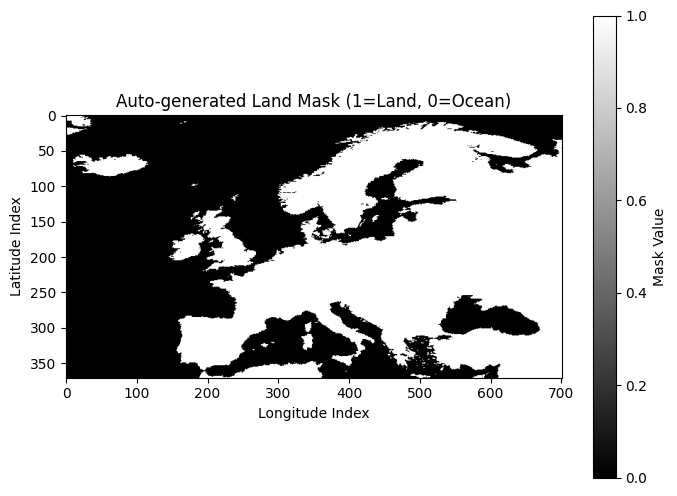

[2025-07-21 19:50:12.184] [INFO] Downsampled array shape: (213, 30, 30, 4)
[2025-07-21 19:50:12.184] [INFO] Downsampled Array (T, H, W, C) info:
[2025-07-21 19:50:12.184] [INFO]   shape: (213, 30, 30, 4)
[2025-07-21 19:50:12.184] [INFO]   dtype: float32
[2025-07-21 19:50:12.193] [INFO]   min: -0.0068, max: 0.7590
[2025-07-21 19:50:12.206] [INFO]   mean: 0.0367, std: 0.1075


In [5]:
# --- STEP 3: LOAD ALL MONTHLY FILES & CONCAT ---
def load_combined_data():
    monthly_arrays = []
    for month in config["months"]:
        arr = np.load(os.path.join(config["intermediate_folder"], f"{month}.npy"))
        monthly_arrays.append(arr)
    final_array = np.concatenate(monthly_arrays, axis=0)  # concat over day axis
    print(f"Final combined shape: {final_array.shape}")  # (days, lat, lon, channels)
    return final_array

data_array = load_combined_data()  # (T, H, W, C)

# Step 3: 自动生成land_mask（所有通道都为0的像元视为海洋）
# land_mask shape: (H, W)，1为陆地，0为海洋
land_mask = (np.any(data_array != 0, axis=(0, 3))).astype(np.float32)
print(f"Auto-generated land_mask shape: {land_mask.shape}, 陆地像元数: {np.sum(land_mask)}")

# 可视化掩膜
plt.figure(figsize=(8, 6))
plt.imshow(land_mask, cmap='gray')
plt.title('Auto-generated Land Mask (1=Land, 0=Ocean)')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.colorbar(label='Mask Value')
plt.show()

# Step 3: 降分辨率可视化
downsampled_array = array_info_displayer.downsample_channels(data_array, target_hw=30)
array_info_displayer.print_info(downsampled_array, name="Downsampled Array (T, H, W, C)")
aframe = downsampled_array[100,:,:,0]

In [6]:
# --- STEP 4: Transform to Tensor ---
def prepare_tensor_data(data):
    # (T, H, W, C) -> (T, C, H, W)
    return np.transpose(data, (0, 3, 1, 2))

tensor_data = prepare_tensor_data(data_array)
print(f"tensor data shape: {tensor_data.shape}")  # (T, C, H, W)


tensor data shape: (213, 4, 371, 701)


In [ ]:
# --- STEP 5: DATASET & DATALOADER Test ---

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # 单位是MB，设置为50MB

from src.datasets import SoilDataset

dataset = SoilDataset(tensor_data, config["input_days"], config["predict_days"])

total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f"Dataset split: train={len(train_set)}, val={len(val_set)}, test={len(test_set)}")

train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)

# ---------------- visualization ----------------
from src.visualize import Visualizer
x_sample, y_sample = dataset[150]


print(f"Sample x shape: {x_sample.shape}, y shape: {y_sample.shape}")
visualizer = Visualizer(lat, lon)
x_to_map = np.transpose(x_sample[-1], (1, 2, 0))
print(f"x_to_map shape: {x_to_map.shape}")  # Should be (H, W, C)
visualizer.plot_variable_day(x_to_map, title="The first sample Day", channel_index=CHANNELS["swvl1"])
# visualizer.plot_tensor_sample(x_sample, y_sample)

from IPython.display import HTML

# Show animation inline for a specific channel (e.g., swvl1)

# Generate animations for different channels and display them separately

# anim_swvl1 = visualizer.animate_tensor_sample(x_sample, y_sample, channel_index=CHANNELS["swvl1"])

# anim_ro_in, anim_ro_out = visualizer.animate_tensor_sample(x_sample, y_sample, channel_index=CHANNELS["e"])

# Display each animation in its own output cell to avoid overlap
# display(HTML(anim_swvl1.to_jshtml()))
# display(HTML(anim_ro_in.to_jshtml()))
# display(HTML(anim_ro_out.to_jshtml()))

In [11]:
x, y = dataset.__getitem__(0)  # Test if dataset works
print(x.shape, y.shape)

import importlib
import src.visualize
importlib.reload(src.visualize)
from src.visualize import Visualizer

# Select only the first channel from x to match y's channel dimension
x_first_channel = x[:, 0:1, :, :]  # shape: (input_days, 1, H, W)
print(f"x_first_channel shape: {x_first_channel.shape}")  # Should be (input_days, 1, H, W)
xy_combined = torch.cat([x_first_channel, y], dim=0)
print(xy_combined.shape)

torch.Size([20, 4, 371, 701]) torch.Size([10, 1, 371, 701])
x_first_channel shape: torch.Size([20, 1, 371, 701])
torch.Size([30, 1, 371, 701])


In [12]:
# --- STEP 7-1: TRAINING LOOP part 1 ---
from src.models import ConvLSTM
from torch.utils.tensorboard import SummaryWriter
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM(input_dim=len(config["use_channels"])).to(device)

# 1. 显示模型结构
print(model)

ConvLSTM(
  (cell): ConvLSTMCell(
    (conv): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [13]:
import datetime

# --- STEP 7-2: TRAINING LOOP part 2 ---

run_name = config["run_name"]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')  # 用于mask后再mean

# TensorBoard writer
writer = SummaryWriter(log_dir=f"runs/soil_conv_lstm_{run_name}")

# Early stopping参数
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# 获取陆地掩膜（假设land_mask已在前面定义，shape: (lat, lon)）
# mask shape: (1, 1, H, W)，与y/pred最后两个维度一致
land_mask_tensor = torch.tensor(land_mask, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)



for epoch in range(config["epochs"]):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        # 3. 损失函数计算前应用掩膜
        mask = land_mask_tensor.expand_as(y)
        loss_map = criterion(pred, y) * mask
        loss = loss_map.sum() / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)

    # 验证集loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in DataLoader(val_set, batch_size=config["batch_size"]):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model(x_val)
            mask_val = land_mask_tensor.expand_as(y_val)
            loss_map_val = criterion(pred_val, y_val) * mask_val
            loss_val = loss_map_val.sum() / mask_val.sum()
            val_loss += loss_val.item()
    avg_val_loss = val_loss / len(val_set)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # 2. Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        timestamp = datetime.datetime.now().strftime("%Y%m%d")
        save_path = os.path.join("params", f"soil_conv_lstm_best_{timestamp}_{run_name}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    # 定期保存检查点
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join("params", f"soil_conv_lstm_{timestamp}_{run_name}_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

writer.close()

[Epoch 1] Train Loss: 0.0299 | Val Loss: 0.0015
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
[Epoch 2] Train Loss: 0.0042 | Val Loss: 0.0009
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
[Epoch 3] Train Loss: 0.0035 | Val Loss: 0.0008
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
[Epoch 4] Train Loss: 0.0033 | Val Loss: 0.0008
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
[Epoch 5] Train Loss: 0.0032 | Val Loss: 0.0008
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
Checkpoint saved to params/soil_conv_lstm_20250721_test-3_epoch5.pth
[Epoch 6] Train Loss: 0.0031 | Val Loss: 0.0008
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
[Epoch 7] Train Loss: 0.0030 | Val Loss: 0.0007
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
[Epoch 8] Train Loss: 0.0027 | Val Loss: 0.0006
Best model saved to params/soil_conv_lstm_best_20250721_test-3.pth
[Epoch 9] T

KeyboardInterrupt: 

In [14]:
# --- Save and Load Model ---

# 加载模型参数
def load_model(model, path="soil_conv_lstm.pth", device='cpu'):
    model.load_state_dict(torch.load(path, map_location=device))
    print(f"Model loaded from {path}")
    return model

# save_model(model,path="soil_conv_lstm-2.pth")
# model = load_model(model, device=device)

Model saved to soil_conv_lstm-2.pth


In [27]:
# --- Reload Visualizer Module ---
import importlib
import src.visualize
importlib.reload(src.visualize)
from src.visualize import Visualizer

# 重新创建visualizer实例以确保有新方法（包括离群点处理）
visualizer = Visualizer(lat, lon)
print("Visualizer module reloaded with outlier handling for metric maps")

Visualizer module reloaded with outlier handling for metric maps


Selected model: params/soil_conv_lstm_best_20250721_test-3.pth
Model loaded from params/soil_conv_lstm_best_20250721_test-3.pth


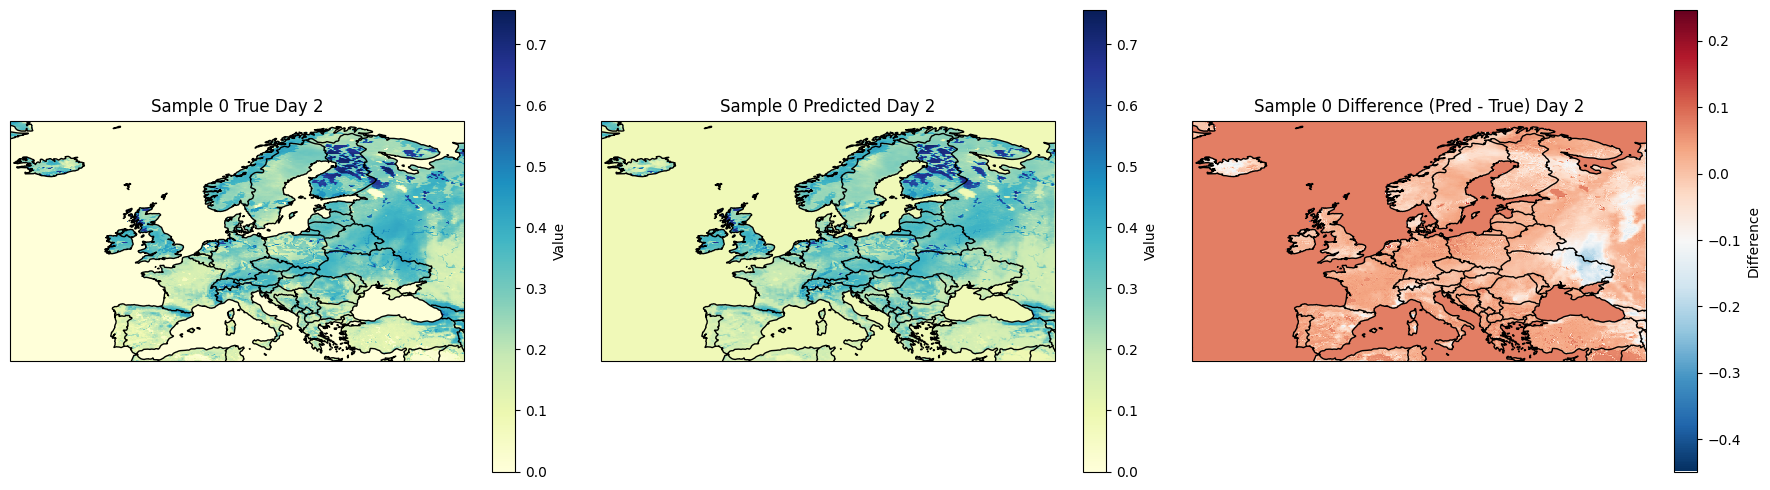

RMSE: 0.0485
MSE: 0.0023
MAE: 0.0376
R2: 0.8215
Valid land pixels: 1232860


In [28]:
# --- STEP 8-1: EVALUATION part 1 ---
import os
import datetime
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def predict_and_visualize(model, dataset, lat, lon, device='cpu', sample_idx=0, visualize_day=0):
    """
    预测并可视化指定的一天
    visualize_day: 要可视化的天数索引 (0-based)
    """
    model.eval()
    x, y_true = dataset[sample_idx]
    x = x.unsqueeze(0).to(device)  # (1, input_days, C, H, W)
    with torch.no_grad():
        y_pred = model(x)  # (1, pred_days, 1, H, W)
    y_pred = y_pred.squeeze(0).cpu().numpy()    # (pred_days, 1, H, W)
    y_true = y_true.numpy()                     # (pred_days, 1, H, W)

    # 只可视化指定的一天
    if visualize_day < y_pred.shape[0]:
        visualizer.plot_comparison(
            y_true[visualize_day], 
            y_pred[visualize_day], 
            day_index=visualize_day,
            title_prefix=f"Sample {sample_idx} "
        )
    else:
        print(f"Warning: visualize_day {visualize_day} exceeds prediction days {y_pred.shape[0]}")
    
    return y_true, y_pred

def compute_metrics_with_mask(y_true, y_pred, land_mask):
    """
    计算指标时应用land_mask，只在陆地区域计算
    y_true, y_pred: (pred_days, 1, H, W)
    land_mask: (H, W)
    """
    # 扩展land_mask到与预测数据相同的维度
    mask_expanded = land_mask[None, None, :, :].repeat(y_true.shape[0], axis=0).repeat(y_true.shape[1], axis=1)
    
    # 只在陆地区域计算
    y_true_masked = y_true[mask_expanded == 1]
    y_pred_masked = y_pred[mask_expanded == 1]
    
    # 移除NaN值
    valid_mask = np.isfinite(y_true_masked) & np.isfinite(y_pred_masked)
    y_true_valid = y_true_masked[valid_mask]
    y_pred_valid = y_pred_masked[valid_mask]
    
    if len(y_true_valid) == 0:
        print("Warning: No valid data points for metric calculation")
        return {"RMSE": np.nan, "MSE": np.nan, "MAE": np.nan, "R2": np.nan}
    
    mse = mean_squared_error(y_true_valid, y_pred_valid)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_valid, y_pred_valid)
    r2 = r2_score(y_true_valid, y_pred_valid)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"Valid land pixels: {len(y_true_valid)}")
    
    return {"RMSE": rmse, "MSE": mse, "MAE": mae, "R2": r2}

def auto_select_best_model(run_name, timestamp=None):
    """
    自动选择最佳模型文件
    """
    if timestamp is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d")
    
    # 优先寻找指定run_name和timestamp的最佳模型
    best_pattern = os.path.join("params", f"soil_conv_lstm_best_{timestamp}_{run_name}.pth")
    best_files = glob.glob(best_pattern)
    
    if best_files:
        return best_files[0]
    
    # 如果没找到，寻找当天的任何最佳模型
    best_pattern_any = os.path.join("params", f"soil_conv_lstm_best_{timestamp}_*.pth")
    best_files_any = glob.glob(best_pattern_any)
    
    if best_files_any:
        print(f"Warning: Specific model for run_name '{run_name}' not found, using {best_files_any[0]}")
        return best_files_any[0]
    
    # 如果还没找到，列出所有可用的最佳模型
    all_best = glob.glob(os.path.join("params", "soil_conv_lstm_best_*.pth"))
    if all_best:
        print(f"Available best models: {all_best}")
        print(f"Using latest: {all_best[-1]}")
        return all_best[-1]
    
    # 最后使用根目录的备用模型
    fallback_path = "soil_conv_lstm-2.pth"
    if os.path.exists(fallback_path):
        print(f"Warning: No best model found, using fallback: {fallback_path}")
        return fallback_path
    
    raise FileNotFoundError("No suitable model file found")

# 自动选择模型文件
try:
    model_path = auto_select_best_model(config["run_name"], "20250721")
    print(f"Selected model: {model_path}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    # 手动指定模型路径
    model_path = input("Please enter the model path manually: ").strip()
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

# 加载模型（推理时建议重新加载，防止训练态）
model_eval = load_model(model, model_path, device=device)
model_eval.eval()

# 选一个测试样本预测并可视化（只显示第一天）
sample_idx = 0  # 你可以换成其它test_set中的样本
visualize_day = 1  # 可视化第一天（0-based索引）
y_true, y_pred = predict_and_visualize(model_eval, test_set, lat, lon, device=device, 
                                     sample_idx=sample_idx, visualize_day=visualize_day)

# 计算指标（应用land_mask）
metrics = compute_metrics_with_mask(y_true, y_pred, land_mask)

In [23]:
y_pred

array([[[[0.39430237, 0.39723206, 0.39616394, ..., 0.        ,
          0.        , 0.        ],
         [0.39509583, 0.3979187 , 0.40072632, ..., 0.        ,
          0.        , 0.        ],
         [0.39839172, 0.4031372 , 0.40786743, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.0640316 ,
          0.11837578, 0.11968994],
         [0.        , 0.        , 0.        , ..., 0.04630788,
          0.0381972 , 0.06356621],
         [0.        , 0.        , 0.        , ..., 0.02548853,
          0.03300921, 0.02587827]]],


       [[[0.39430237, 0.39723206, 0.39616394, ..., 0.        ,
          0.        , 0.        ],
         [0.39509583, 0.3979187 , 0.40072632, ..., 0.        ,
          0.        , 0.        ],
         [0.39839172, 0.4031372 , 0.40786743, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.0640246 ,
          0.11835226, 0

/tmp/ipykernel_1948704/2683889022.py:66: RuntimeWarning: divide by zero encountered in divide
  1 - sq_err_values / denominator,
/tmp/ipykernel_1948704/2683889022.py:85: RuntimeWarning: Mean of empty slice
  rmse_map = np.sqrt(np.nanmean(sq_err_stack, axis=0))  # shape: (H, W)


平均指标（1~predict_days，仅陆地区域）:
RMSE均值: 0.0481, MAE均值: 0.0376, R2均值: 0.8202


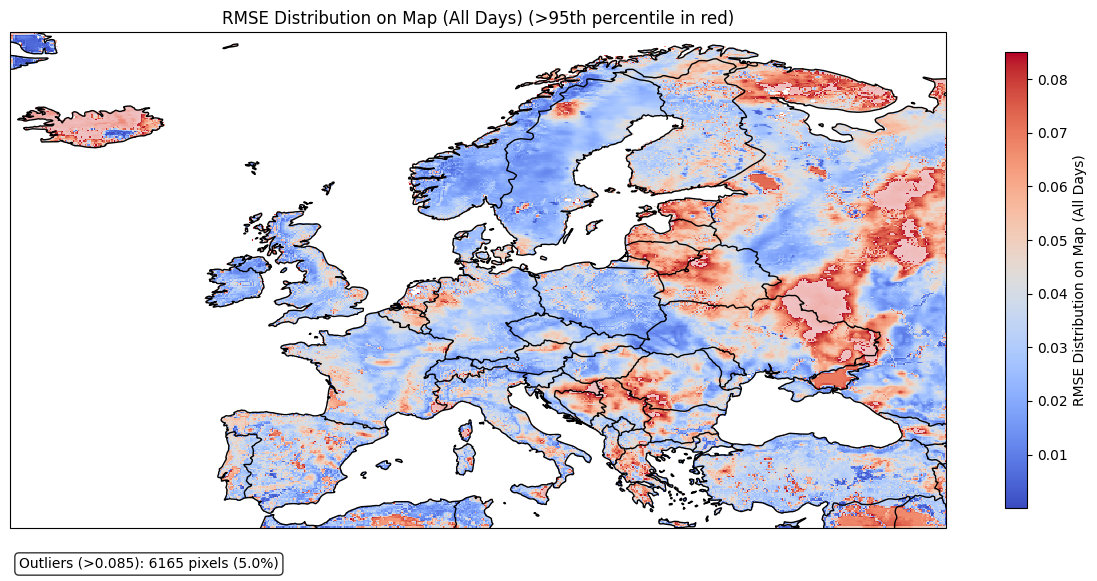

Metric statistics:
  Valid pixels: 123286
  Min: 0.0000, Max: 0.4630
  95th percentile: 0.0851
  Outliers: 6165 pixels (5.0%)


/tmp/ipykernel_1948704/2683889022.py:97: RuntimeWarning: Mean of empty slice
  mae_map_avg = np.nanmean(np.stack(mae_map_list), axis=0)  # 平均MAE地图


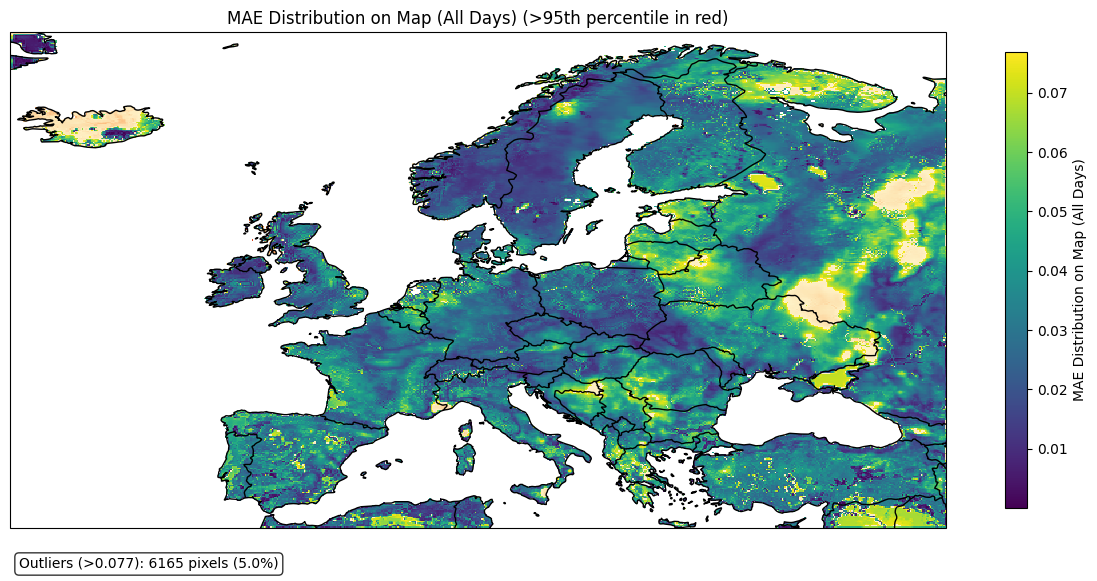

Metric statistics:
  Valid pixels: 123286
  Min: 0.0000, Max: 0.4623
  95th percentile: 0.0769
  Outliers: 6165 pixels (5.0%)


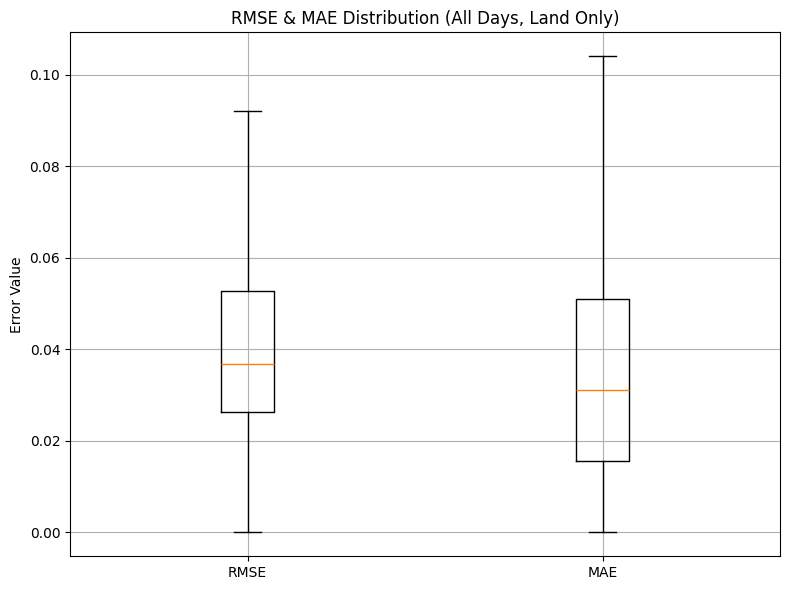

/tmp/ipykernel_1948704/2683889022.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc = desc.applymap(lambda x: round(x, 4))


累积分布表 (仅陆地区域):
             RMSE          MAE               R2
count 123286.0000 1232860.0000     1232860.0000
mean       0.0423       0.0376      -29526.6796
std        0.0237       0.0306    10757050.1746
min        0.0000       0.0000 -9512461312.0000
25%        0.0264       0.0156           0.0678
50%        0.0368       0.0310           0.8493
75%        0.0527       0.0510           0.9583
max        0.4630       0.5286           1.0000


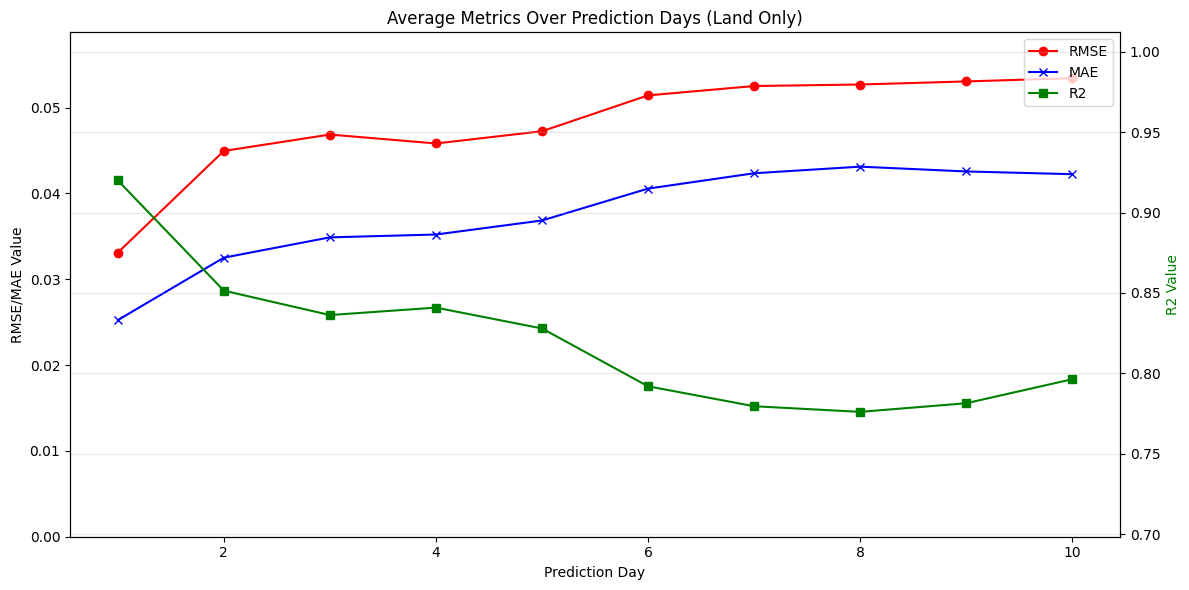

: 

In [ ]:
# --- STEP 8-2: EVALUATION part 2 ---
# 1. 生成从第1到第predict_days天的metrics总平均指标结果
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

predict_days = y_pred.shape[0]
lat_dim, lon_dim = y_pred.shape[2], y_pred.shape[3]

# 扩展land_mask到与预测数据相同的维度
land_mask_expanded = land_mask[None, None, :, :].repeat(predict_days, axis=0).repeat(1, axis=1)

rmse_list, mae_list, r2_list = [], [], []
rmse_map_list, mae_map_list, r2_map_list = [], [], []

sq_err_stack = []
for t in range(predict_days):
    # 应用land_mask
    y_true_t = y_true[t][land_mask_expanded[t] == 1]
    y_pred_t = y_pred[t][land_mask_expanded[t] == 1]
    
    # 移除NaN值
    mask = np.isfinite(y_true_t) & np.isfinite(y_pred_t)
    y_true_valid = y_true_t[mask]
    y_pred_valid = y_pred_t[mask]
    
    if len(y_true_valid) > 0:
        rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
        mae = mean_absolute_error(y_true_valid, y_pred_valid)
        r2 = r2_score(y_true_valid, y_pred_valid)
    else:
        rmse = mae = r2 = np.nan
        
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    
    # Per-pixel metrics (只在陆地区域)
    sq_err = np.full((lat_dim, lon_dim), np.nan)
    mae_map = np.full((lat_dim, lon_dim), np.nan)
    r2_map = np.full((lat_dim, lon_dim), np.nan)
    
    # 计算陆地区域的逐像素误差
    land_indices = np.where(land_mask == 1)
    # 直接对陆地区域进行向量化计算
    land_mask_2d = land_mask == 1
    y_true_land = y_true[t, 0, land_mask_2d]
    y_pred_land = y_pred[t, 0, land_mask_2d]

    # 找到有效值的mask
    valid_mask = np.isfinite(y_true_land) & np.isfinite(y_pred_land)
    y_true_valid_land = y_true_land[valid_mask]
    y_pred_valid_land = y_pred_land[valid_mask]

    # 向量化计算误差
    if len(y_true_valid_land) > 0:
        # 计算squared error
        sq_err_values = (y_pred_valid_land - y_true_valid_land)**2
        mae_values = np.abs(y_pred_valid_land - y_true_valid_land)
        
        # 计算简化的R2值
        mean_true = np.nanmean(y_true_valid_land)
        denominator = (y_true_valid_land - mean_true)**2
        r2_values = np.where(denominator != 0, 
                            1 - sq_err_values / denominator, 
                            0)
        
        # 找到有效陆地像素的索引
        valid_land_indices = np.where(land_mask_2d)
        valid_indices_filtered = (valid_land_indices[0][valid_mask], 
                                 valid_land_indices[1][valid_mask])
        
        # 将结果填充到对应位置
        sq_err[valid_indices_filtered] = sq_err_values
        mae_map[valid_indices_filtered] = mae_values
        r2_map[valid_indices_filtered] = r2_values
    
    sq_err_stack.append(sq_err)
    mae_map_list.append(mae_map)
    r2_map_list.append(r2_map)

# 计算平均RMSE map
sq_err_stack = np.stack(sq_err_stack, axis=0)  # shape: (T, H, W)
rmse_map = np.sqrt(np.nanmean(sq_err_stack, axis=0))  # shape: (H, W)

print("平均指标（1~predict_days，仅陆地区域）:")
print("RMSE均值: {:.4f}, MAE均值: {:.4f}, R2均值: {:.4f}".format(
    np.nanmean(rmse_list), np.nanmean(mae_list), np.nanmean(r2_list)
))

# 2. 可视化RMSE Distribution on Map (限制上限并标记离群点)
visualizer.plot_metric_map(rmse_map, title="RMSE Distribution on Map (All Days)", 
                          cmap='coolwarm', outlier_percentile=95)

# 2.1 可视化MAE Distribution on Map (可选)
mae_map_avg = np.nanmean(np.stack(mae_map_list), axis=0)  # 平均MAE地图
visualizer.plot_metric_map(mae_map_avg, title="MAE Distribution on Map (All Days)", 
                          cmap='viridis', outlier_percentile=95)

# 3. RMSE 和 MAE 的总分布箱型图
# 使用计算得到的rmse_map和mae_map_list来获取flatten的数组
all_rmse = rmse_map.flatten()
all_mae = np.stack(mae_map_list).flatten()

# 只保留陆地区域的有效值
all_rmse_valid = all_rmse[~np.isnan(all_rmse)]
all_mae_valid = all_mae[~np.isnan(all_mae)]

visualizer.plot_box([all_rmse_valid, all_mae_valid], 
                   labels=['RMSE', 'MAE'], 
                   title="RMSE & MAE Distribution (All Days, Land Only)",
                   ylabel="Error Value")

# 4. 统计RMSE，MAE，R2的累积分布表
all_r2 = np.stack(r2_map_list).flatten()
all_r2_valid = all_r2[~np.isnan(all_r2)]

metrics_dict = {
    'RMSE': all_rmse_valid,
    'MAE': all_mae_valid,
    'R2': all_r2_valid
}
summary_df = pd.DataFrame({k: pd.Series(v) for k, v in metrics_dict.items()})
desc = summary_df.describe(percentiles=[.25, .5, .75])
desc = desc.applymap(lambda x: round(x, 4))
print("累积分布表 (仅陆地区域):")
with pd.option_context('display.float_format', '{:.4f}'.format):
    print(desc)

# 5. 绘制总平均rmse，mae，和r2随预测天数预测的折线图
plt.figure(figsize=(12, 6))

# 创建两个y轴
ax1 = plt.gca()
ax2 = ax1.twinx()

# 在左侧y轴绘制RMSE和MAE
line1 = ax1.plot(range(1, predict_days+1), rmse_list, marker='o', label='RMSE', color='red')
line2 = ax1.plot(range(1, predict_days+1), mae_list, marker='x', label='MAE', color='blue')
ax1.set_xlabel("Prediction Day")
ax1.set_ylabel("RMSE/MAE Value", color='black')
ax1.set_ylim(0, max(max(rmse_list), max(mae_list)) * 1.1)

# 在右侧y轴绘制R2
line3 = ax2.plot(range(1, predict_days+1), r2_list, marker='s', label='R2', color='green')
ax2.set_ylabel("R2 Value", color='green')
ax2.set_ylim(min(r2_list) * 0.9, max(r2_list) * 1.1)

# 合并图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title("Average Metrics Over Prediction Days (Land Only)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- Additional Analysis (Optional) ---
# 如果需要查看具体的误差分布或进行其他分析，可以在这里添加代码

# 例如：查看MAE的样本分布
plt.figure(figsize=(12, 4))
sample_size = min(200, len(all_mae_valid))
sample_indices = np.random.choice(len(all_mae_valid), sample_size, replace=False)
sample_mae = all_mae_valid[sample_indices]

plt.plot(np.arange(1, sample_size + 1), sample_mae, label='MAE Sample', marker='o', markersize=2)
plt.xlabel(f"Sample Index (1 ~ {sample_size})")
plt.ylabel("MAE Value")
plt.title(f"Sample MAE Distribution (Random {sample_size} Land Pixels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Total valid land pixels: {len(all_mae_valid)}")
print(f"Mean MAE: {np.mean(all_mae_valid):.4f}")
print(f"Std MAE: {np.std(all_mae_valid):.4f}")

In [ ]:
# --- Summary Statistics ---
# 展示最终的汇总统计

print("=== EVALUATION SUMMARY ===")
print(f"Model used: {model_path}")
print(f"Test sample index: {sample_idx}")
print(f"Visualized day: {visualize_day + 1}")
print(f"Prediction days: {predict_days}")
print(f"Total land pixels: {np.sum(land_mask)}")
print(f"Valid data points per day: ~{len(all_mae_valid) // predict_days}")

print("\n=== AVERAGE METRICS (LAND ONLY) ===")
print(f"RMSE: {np.nanmean(rmse_list):.4f} ± {np.nanstd(rmse_list):.4f}")
print(f"MAE:  {np.nanmean(mae_list):.4f} ± {np.nanstd(mae_list):.4f}")
print(f"R2:   {np.nanmean(r2_list):.4f} ± {np.nanstd(r2_list):.4f}")

print(f"\n=== PIXEL-WISE STATISTICS ===")
print(f"RMSE per pixel: {np.nanmean(all_rmse_valid):.4f} ± {np.nanstd(all_rmse_valid):.4f}")
print(f"MAE per pixel:  {np.nanmean(all_mae_valid):.4f} ± {np.nanstd(all_mae_valid):.4f}")
print(f"R2 per pixel:   {np.nanmean(all_r2_valid):.4f} ± {np.nanstd(all_r2_valid):.4f}")

print(f"\n=== OUTLIER ANALYSIS ===")
rmse_95th = np.nanpercentile(all_rmse_valid, 95)
mae_95th = np.nanpercentile(all_mae_valid, 95)
rmse_outliers = np.sum(all_rmse_valid > rmse_95th)
mae_outliers = np.sum(all_mae_valid > mae_95th)
print(f"RMSE 95th percentile: {rmse_95th:.4f}")
print(f"RMSE outliers (>95th): {rmse_outliers} pixels ({rmse_outliers/len(all_rmse_valid)*100:.1f}%)")
print(f"MAE 95th percentile: {mae_95th:.4f}")
print(f"MAE outliers (>95th): {mae_outliers} pixels ({mae_outliers/len(all_mae_valid)*100:.1f}%)")

array([0., 0., 0., ..., 0., 0., 0.], shape=(2600710,), dtype=float32)